# **Ponderada #02: Teste A/B em Simulador de Leitura de Notícias (Versão 2)**

## 1. Objetivo

Projetar, simular e analisar um **teste A/B** em um site de notícias (por exemplo, a *Gazeta*), avaliando como mudanças editoriais e de apresentação impactam o comportamento dos leitores.

Esta versão traz:
- Explicações adicionais em cada etapa.
- Novas variáveis para `Leitor` e `Noticia`.
- Separação de passos em células independentes.

## 2. Contexto e Definição da Alteração

Um editor deseja testar como diferentes versões de uma notícia impactam o engajamento dos leitores. Escolhemos alterar o estilo de escrita da notícia: uma versão terá uma escrita formal e detalhada, enquanto a outra terá uma escrita informal e resumida.

**Hipótese de Negócio**

>A hipótese é que notícias escritas com estilo informal e resumido aumentarão a taxa de clique (CTR) em comparação às notícias formais, especialmente entre leitores mais jovens ou com pouco tempo disponível para leitura.


### 2.1 Métricas

Principal:
- CTR (Taxa de clique): Proporção de leitores que clicaram na notícia.

Secundárias:
- Tempo Médio de Leitura: Tempo que os leitores passam lendo após clicar.

- Taxa de rejeição (Bounce Rate): Proporção de leitores que clicaram, mas saíram rapidamente sem ler totalmente.

**Justificativa das Funções e Métricas:**
- CTR permite avaliar diretamente a hipótese principal: impacto do estilo da notícia no interesse imediato do leitor.

- Tempo Médio de Leitura e Bounce Rate ajudam a entender não só se a notícia é clicada, mas se é realmente consumida, indicando profundidade de engajamento além do clique inicial.

---

## 3. Construção da Simulação
Nesta seção construímos o simulador passo a passo: modelagem de classes, lógica de decisão e geração de leitores.

### 3.a) Importações
Importamos pacotes para geração de números aleatórios, estatística e manipulação de dados.

In [1]:
# Bibliotecas básicas para simulação e análise
%pip install pandas
%pip install scipy
%pip install statsmodels
%pip install matplotlib
%pip install seaborn

import numpy as np
import random
import pandas as pd
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind, chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns


seed = 42
random.seed(seed)
np.random.seed(seed)

Note: you may need to restart the kernel to use updated packages.
  Using cached scipy-1.15.3-cp313-cp313-win_amd64.whl.metadata (60 kB)
Using cached scipy-1.15.3-cp313-cp313-win_amd64.whl (41.0 MB)
Note: you may need to restart the kernel to use updated packages.
  Using cached statsmodels-0.14.4-cp313-cp313-win_amd64.whl.metadata (9.5 kB)
  Using cached patsy-1.0.1-py2.py3-none-any.whl.metadata (3.3 kB)
Using cached statsmodels-0.14.4-cp313-cp313-win_amd64.whl (9.8 MB)
Using cached patsy-1.0.1-py2.py3-none-any.whl (232 kB)

   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [sta

### 3.b) Classe `Leitor`

A classe Leitor modela um leitor típico em nossa simulação, com características que influenciam diretamente seu comportamento diante de uma notícia. Ela possui:

- **idade**: afeta indiretamente as preferências e o comportamento em relação à leitura.

- **categoria_preferida**: determina a compatibilidade entre o interesse do leitor e a categoria da notícia.

- **tempo_disp**: o tempo disponível que o leitor tem para consumir a notícia, afetando a decisão e o engajamento real.

- **interesse**: representa o nível geral de interesse do leitor por notícias, influenciando diretamente a probabilidade de clique.

- **preferencia_estilo**: define a preferência do leitor pelo estilo da escrita (formal ou informal), influenciando diretamente sua decisão inicial.

A classe possui três métodos principais:

- **decide_clique(noticia)**: decide se o leitor clica ou não na notícia considerando categoria, estilo e tempo disponível.

- **gera_tempo_leitura(noticia)**: gera o tempo gasto pelo leitor na notícia, influenciado pela categoria e interesse.

- **verifica_rejeicao(noticia, tempo_gasto)**: determina se o clique resultou em rejeição (bounce) baseado no tempo efetivamente gasto lendo em relação ao tempo total esperado.

In [2]:
import numpy as np

class Leitor:
    def __init__(self, idade, categoria_preferida, tempo_disp, interesse, preferencia_estilo):
        self.idade = idade
        self.categoria_preferida = categoria_preferida
        self.tempo_disp = tempo_disp
        self.interesse = interesse
        self.preferencia_estilo = preferencia_estilo

    def decide_clique(self, noticia):
        afinidade_categoria = 1 if self.categoria_preferida == noticia.categoria else 0.5
        afinidade_estilo = 1 if self.preferencia_estilo == noticia.estilo_escrita else 0.7
        tempo_suficiente = 1 if self.tempo_disp >= noticia.tempo_estimado else 0.5

        probabilidade_base = self.interesse * afinidade_categoria * afinidade_estilo * tempo_suficiente

        return np.random.rand() < probabilidade_base

    def gera_tempo_leitura(self, noticia):
        tempo_real = min(self.tempo_disp, noticia.tempo_estimado)
        interesse_real = self.interesse * (1 if noticia.categoria == self.categoria_preferida else 0.8)

        tempo_gasto = np.random.normal(loc=tempo_real * interesse_real, scale=0.5)

        return max(tempo_gasto, 0.1)

    def verifica_rejeicao(self, noticia, tempo_gasto):
        return tempo_gasto < (0.3 * noticia.tempo_estimado)


### 3.c) Classe `Noticia`

A classe Noticia modela as características essenciais de uma notícia que será exibida para os leitores durante a simulação do teste A/B. Cada atributo é projetado para refletir fatores que podem influenciar a decisão e engajamento do leitor:

- **id**: identificador único para rastrear cada notícia.

- **categoria**: define o assunto principal da notícia, permitindo avaliar afinidades com as preferências do leitor.

- **manchete**: o texto inicial que é exibido ao leitor e que influencia diretamente a decisão de clique.

- **tempo_estimado**: tempo médio estimado que leva para ler completamente a notícia.

- **estilo_escrita**: determina se a notícia possui escrita formal e detalhada ou informal e resumida, sendo essencial para o teste A/B.

In [3]:
class Noticia:
    def __init__(self, id, categoria, manchete, tempo_estimado, estilo_escrita):
        self.id = id
        self.categoria = categoria
        self.manchete = manchete
        self.tempo_estimado = tempo_estimado
        self.estilo_escrita = estilo_escrita


### 3.d) Simulação da Decisão de Leitura


A decisão sobre o clique de um leitor em uma notícia é simulada no método `decide_clique()` da classe `Leitor`. O processo ocorre passo a passo, considerando as seguintes condições:

1. **Afinidade de Categoria**:  
   - Se a categoria da notícia coincide com a categoria preferida do leitor, a afinidade é máxima (valor = **1**), aumentando a probabilidade.
   - Caso contrário, essa afinidade diminui para **0,5**, reduzindo significativamente a chance de clique.

2. **Preferência por Estilo de Escrita**:  
   - Caso o estilo da notícia (formal ou informal) corresponda ao estilo preferido pelo leitor, a afinidade será alta (**1**), aumentando a probabilidade.
   - Caso contrário, o valor cai para **0,7**, diminuindo moderadamente a probabilidade.

3. **Disponibilidade de Tempo**:  
   - Se o leitor possuir tempo suficiente para ler integralmente a notícia, a probabilidade permanece alta (**1**).
   - Se o tempo disponível for insuficiente, essa probabilidade diminui consideravelmente (**0,5**).

4. **Cálculo da Probabilidade Final**:  
   Multiplica-se o nível geral de interesse do leitor pelas afinidades anteriores. Quanto maiores forem esses fatores, maior será a probabilidade de clique.

5. **Decisão Aleatória**:  
   Finalmente, uma decisão de clique é tomada comparando essa probabilidade final com um número aleatório. Se o valor sorteado for menor que a probabilidade calculada, ocorre o clique.

Desta forma, o método `decide_clique()` da classe `Leitor` permite simular realisticamente o comportamento dos leitores diante de diferentes versões da notícia.

### 3.e) Geração da População de Leitores


### 3.e) Geração da População de Leitores

Criamos uma amostra realista de leitores utilizando distribuições estatísticas adequadas para cada atributo, com base em características comuns encontradas em populações reais:

- **Idade**:  
  Gerada a partir de uma distribuição normal com média de **35 anos** e desvio-padrão de **10 anos**, ajustada para valores entre 18 e 80 anos, representando a faixa etária mais comum de leitores adultos.

- **Categoria Preferida**:  
  Escolhida aleatoriamente a partir de uma distribuição categórica com pesos diferentes baseados em interesse geral, sendo:
  - Esporte (25%)
  - Política (20%)
  - Tecnologia (20%)
  - Entretenimento (20%)
  - Economia (15%)

- **Tempo Disponível**:  
  Gerado por uma distribuição gama (shape=2, scale=5) resultando em média aproximada de 10 minutos, representando de forma realista o tempo médio que usuários têm para consumir notícias online.

- **Interesse**:  
  Gerado por uma distribuição beta com parâmetros (a=2, b=5), indicando que a maioria dos leitores possui um interesse moderado a baixo (maior concentração abaixo de 0,5), coerente com o comportamento típico dos leitores online.

- **Preferência de Estilo (Formal ou Informal)**:  
  Distribuída conforme faixa etária:
  - Leitores com menos de 40 anos têm maior preferência por estilo informal (60% informal, 40% formal).
  - Leitores acima de 40 anos preferem o estilo formal com mais frequência (80% formal, 20% informal).


In [4]:
categorias = ['política', 'esporte', 'tecnologia', 'entretenimento', 'economia']
estilos = ['formal', 'informal']

def gerar_leitores(n):
    leitores = []
    for _ in range(n):
        idade = int(np.random.normal(35, 10))
        idade = max(18, min(idade, 80))

        categoria_preferida = random.choices(
            categorias,
            weights=[0.2, 0.25, 0.2, 0.2, 0.15]
        )[0]

        tempo_disp = np.random.gamma(shape=2, scale=5)
        tempo_disp = max(1, min(tempo_disp, 30))

        interesse = np.clip(np.random.beta(a=2, b=5), 0.1, 1.0)

        preferencia_estilo = random.choices(
            estilos,
            weights=[0.4 if idade >= 40 else 0.2, 0.6 if idade < 40 else 0.8]
        )[0]

        leitor = Leitor(idade, categoria_preferida, tempo_disp, interesse, preferencia_estilo)
        leitores.append(leitor)

    return leitores

## 4. Execução do Teste A/B
Funções para aplicar mudança e coletar dados separados em células.

### 4.a) `gerar_noticia_ab()`

A função `gerar_noticia_ab()` cria versões alternativas das notícias para uso específico em testes A/B, alterando o estilo de escrita de acordo com a versão especificada:

- **Versão A**:  
  Mantém a notícia original, com estilo formal e detalhado.

- **Versão B**:  
  Altera automaticamente o estilo da notícia para informal, reduzindo seu tempo estimado de leitura em cerca de 30%, indicando um conteúdo mais curto e direto. Além disso, a manchete recebe um complemento indicando que se trata de uma versão resumida e informal.

Desta forma, garantimos que as notícias do grupo B sejam sempre modificadas, permitindo uma comparação clara e objetiva entre as versões testadas no experimento.


In [5]:
def gerar_noticia_ab(id, categoria, manchete, tempo_estimado, versao='A'):
    estilo_original = 'formal'
    estilo_alternativo = 'informal'

    if versao == 'B':
        estilo_escrita = estilo_alternativo if estilo_original == 'formal' else estilo_original
        manchete_modificada = manchete + " [Versão Resumida e Informal]"
        tempo_estimado = max(1, tempo_estimado * 0.7)  # Reduz tempo estimado para refletir menor extensão
    else:
        estilo_escrita = estilo_original
        manchete_modificada = manchete

    return Noticia(id, categoria, manchete_modificada, tempo_estimado, estilo_escrita)

### 4.b) `coletar_dados_teste_ab()`

A função `coletar_dados_teste_ab()` realiza a simulação completa do teste A/B seguindo estes passos:

1. **Geração de Notícias**:  
   Inicialmente gera um conjunto aleatório de notícias, com tempo estimado entre 2 e 8 minutos e categorias variadas.

2. **Criação dos Grupos A e B**:  
   A partir das notícias geradas, é criado automaticamente o grupo B com alteração no estilo (informal e resumido) através da função `gerar_noticia_ab()`.

3. **Simulação com Leitores**:  
   Uma população de leitores é gerada com características realistas (idade, interesse, tempo disponível, categoria e estilo preferidos). Cada leitor é apresentado a uma notícia aleatória da versão testada (A ou B), e suas decisões de clique e leitura são simuladas pelos métodos da classe `Leitor`.

4. **Cálculo de Métricas**:  
   São coletadas métricas essenciais do teste:
   - **CTR (Taxa de Clique)**: Proporção de leitores que clicaram na notícia.
   - **Tempo Médio de Leitura**: Tempo médio gasto pelos leitores nas notícias clicadas.
   - **Bounce Rate (Taxa de Rejeição)**: Proporção dos leitores que abandonaram rapidamente a notícia após clicar (menos que 30% do tempo estimado).

5. **Retorno dos Resultados**:  
   Ao fim da simulação, a função retorna um DataFrame com as métricas comparativas das versões A e B, permitindo uma análise clara e objetiva do impacto da mudança no estilo das notícias.


In [6]:
def gerar_noticias(n):
    categorias = ['política', 'esporte', 'tecnologia', 'entretenimento', 'economia']
    noticias = []
    for i in range(n):
        categoria = random.choice(categorias)
        manchete = f"Nova notícia sobre {categoria.capitalize()}"
        tempo_estimado = np.random.uniform(2, 8)  # tempo médio entre 2 a 8 minutos
        noticias.append(Noticia(i, categoria, manchete, tempo_estimado, 'formal'))
    return noticias

def coletar_dados_teste_ab(num_leitores, num_noticias):
    leitores = gerar_leitores(num_leitores)
    noticias_a = gerar_noticias(num_noticias)
    noticias_b = [gerar_noticia_ab(noticia.id, noticia.categoria, noticia.manchete, noticia.tempo_estimado, 'B') for noticia in noticias_a]

    resultados = []

    for versao, noticias in [('A', noticias_a), ('B', noticias_b)]:
        cliques, tempos, rejeicoes, total = 0, [], 0, 0

        for leitor in leitores:
            noticia = random.choice(noticias)
            if leitor.decide_clique(noticia):
                cliques += 1
                tempo_gasto = leitor.gera_tempo_leitura(noticia)
                tempos.append(tempo_gasto)
                if leitor.verifica_rejeicao(noticia, tempo_gasto):
                    rejeicoes += 1
            total += 1

        ctr = cliques / total if total else 0
        tempo_medio = np.mean(tempos) if tempos else 0
        bounce_rate = rejeicoes / cliques if cliques else 0

        resultados.append({
            'Versão': versao,
            'CTR': ctr,
            'Tempo Médio Leitura': tempo_medio,
            'Bounce Rate': bounce_rate
        })

    return pd.DataFrame(resultados)

### 4.c) Visualizações das distribuições

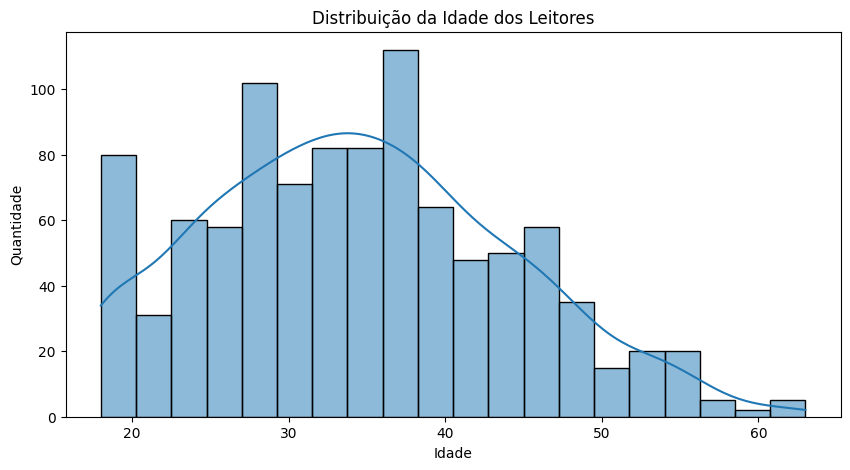

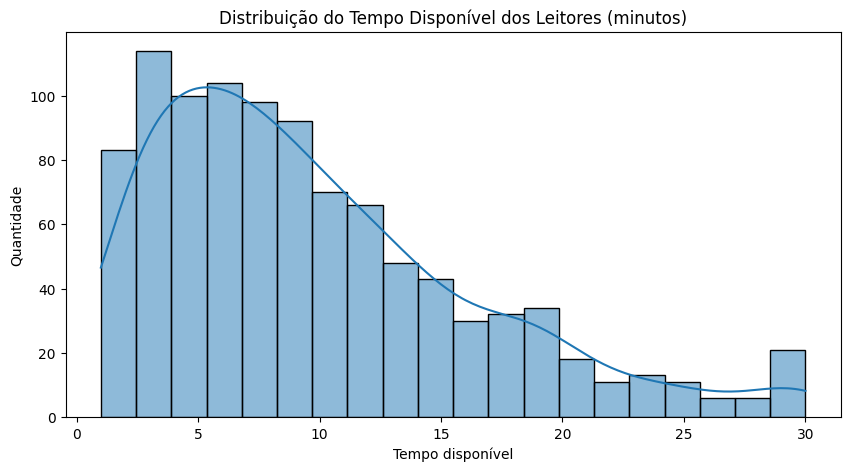

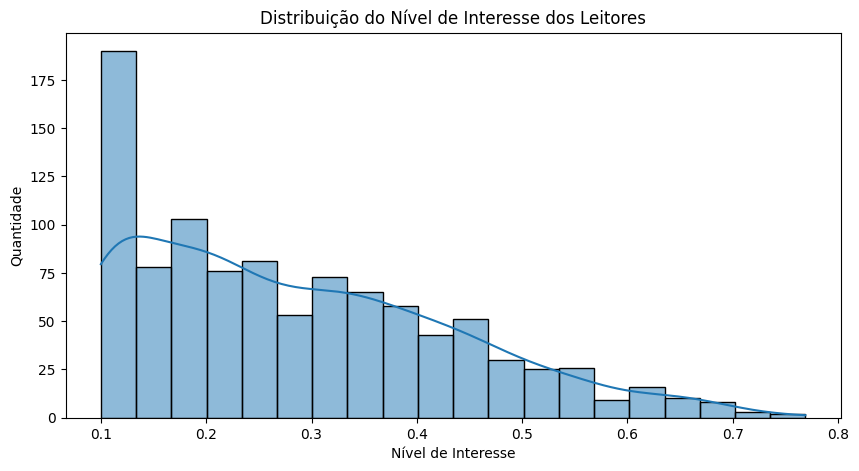

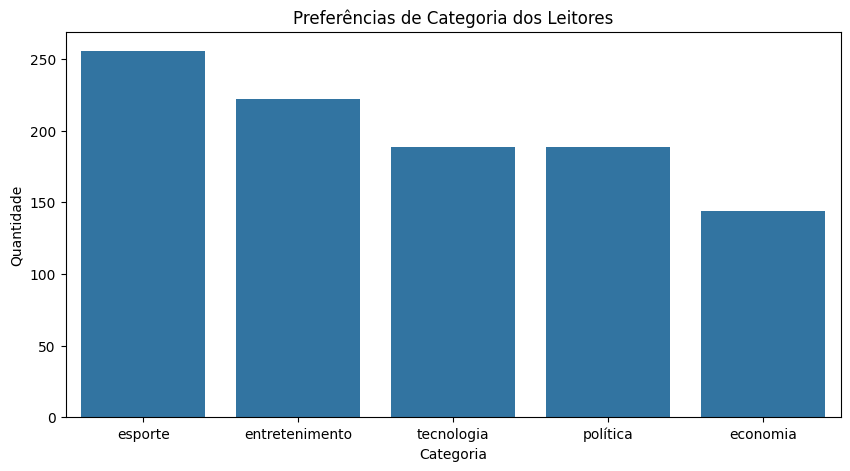

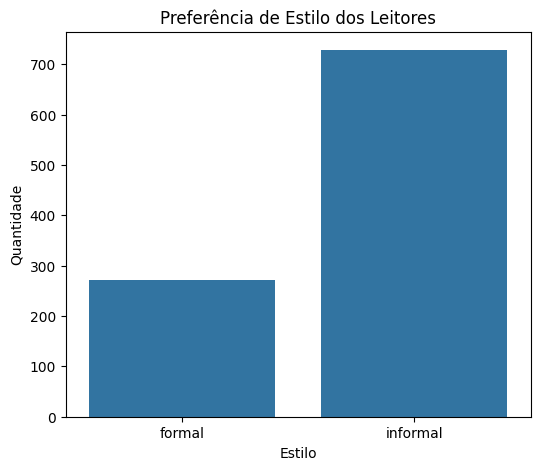

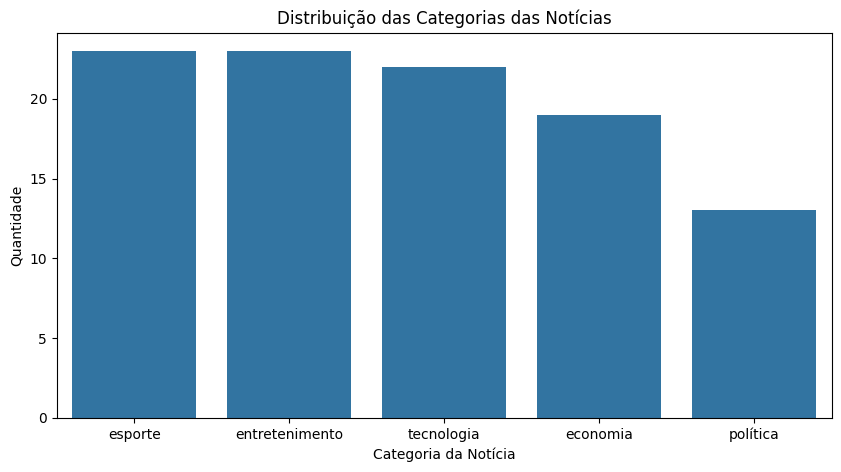

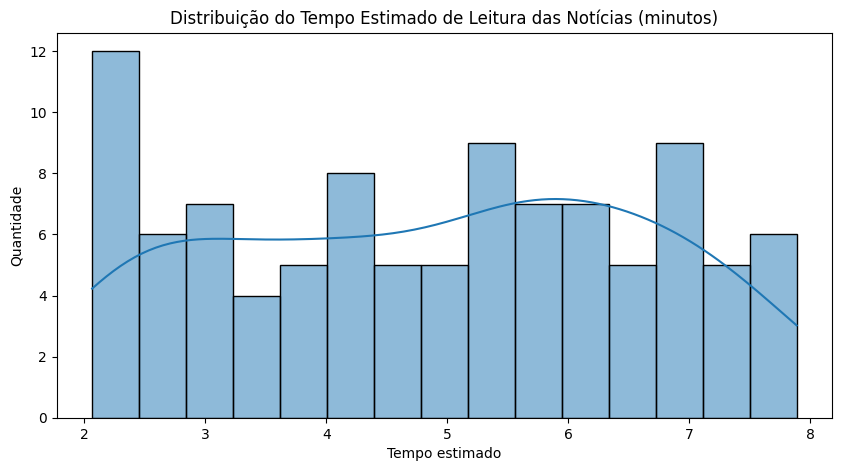

In [7]:

leitores = gerar_leitores(1000)
noticias = gerar_noticias(100)

# Preparando os dados dos leitores
idades = [leitor.idade for leitor in leitores]
tempo_disp = [leitor.tempo_disp for leitor in leitores]
interesse = [leitor.interesse for leitor in leitores]
categorias_pref = [leitor.categoria_preferida for leitor in leitores]
preferencia_estilo = [leitor.preferencia_estilo for leitor in leitores]

# Preparando os dados das notícias
categorias_noticias = [noticia.categoria for noticia in noticias]
tempo_estimado_noticias = [noticia.tempo_estimado for noticia in noticias]

# Visualizando distribuição de idade dos leitores
plt.figure(figsize=(10, 5))
sns.histplot(idades, bins=20, kde=True)
plt.title('Distribuição da Idade dos Leitores')
plt.xlabel('Idade')
plt.ylabel('Quantidade')
plt.show()

# Visualizando distribuição do tempo disponível dos leitores
plt.figure(figsize=(10, 5))
sns.histplot(tempo_disp, bins=20, kde=True)
plt.title('Distribuição do Tempo Disponível dos Leitores (minutos)')
plt.xlabel('Tempo disponível')
plt.ylabel('Quantidade')
plt.show()

# Visualizando distribuição de interesse dos leitores
plt.figure(figsize=(10, 5))
sns.histplot(interesse, bins=20, kde=True)
plt.title('Distribuição do Nível de Interesse dos Leitores')
plt.xlabel('Nível de Interesse')
plt.ylabel('Quantidade')
plt.show()

# Visualizando preferências por categorias
plt.figure(figsize=(10, 5))
sns.countplot(x=categorias_pref, order=pd.Series(categorias_pref).value_counts().index)
plt.title('Preferências de Categoria dos Leitores')
plt.xlabel('Categoria')
plt.ylabel('Quantidade')
plt.show()

# Visualizando preferências de estilo de escrita
plt.figure(figsize=(6, 5))
sns.countplot(x=preferencia_estilo)
plt.title('Preferência de Estilo dos Leitores')
plt.xlabel('Estilo')
plt.ylabel('Quantidade')
plt.show()

# Distribuição das categorias das notícias
plt.figure(figsize=(10, 5))
sns.countplot(x=categorias_noticias, order=pd.Series(categorias_noticias).value_counts().index)
plt.title('Distribuição das Categorias das Notícias')
plt.xlabel('Categoria da Notícia')
plt.ylabel('Quantidade')
plt.show()

# Distribuição do tempo estimado das notícias
plt.figure(figsize=(10, 5))
sns.histplot(tempo_estimado_noticias, bins=15, kde=True)
plt.title('Distribuição do Tempo Estimado de Leitura das Notícias (minutos)')
plt.xlabel('Tempo estimado')
plt.ylabel('Quantidade')
plt.show()


## 5. Avaliação Estatística do Teste A/B

Para validar cientificamente os resultados do teste A/B, realizamos testes estatísticos rigorosos sobre cada métrica:




Realizamos testes estatísticos completos aplicando **Z-Test**, **Teste T de Student** e **Teste Qui-Quadrado** para todas as métricas avaliadas, garantindo uma avaliação robusta dos resultados do experimento.

### Métricas Avaliadas:

- **CTR (Taxa de clique)**
- **Tempo Médio de Leitura**
- **Bounce Rate (Taxa de rejeição)**

### Detalhes dos Testes Estatísticos Utilizados:

| Teste Estatístico           | Aplicação                                                     |
|-----------------------------|---------------------------------------------------------------|
| **Z-Test para proporções**  | Avalia diferenças significativas entre proporções, como CTR e Bounce Rate. |
| **Teste T de Student**      | Avalia diferenças significativas entre as médias contínuas, como Tempo Médio de Leitura. Usado aqui também para fins comparativos nas outras métricas.|
| **Teste Qui-Quadrado**      | Avalia diferenças entre frequências observadas e esperadas em dados categóricos (CTR, Bounce Rate), e aplicado aqui para a variável contínua (Tempo Médio) após categorização (acima ou abaixo da média).|

### Interpretação dos Resultados:

- Cada métrica foi avaliada pelos três testes, gerando um p-valor.
- Um p-valor inferior a **0.05** indica que a diferença entre as versões A e B é estatisticamente significativa.
- A aplicação múltipla de testes para cada métrica permite confirmar a robustez dos resultados obtidos.

A tabela gerada fornece uma visão clara e abrangente do impacto estatístico da versão B sobre cada métrica analisada, permitindo concluir se as alterações propostas pelo teste A/B proporcionaram melhorias significativas.


In [8]:
def executar_avaliacao_ab(num_leitores=1000, num_noticias=30):
    leitores = gerar_leitores(num_leitores)
    noticias_a = gerar_noticias(num_noticias)
    noticias_b = [gerar_noticia_ab(n.id, n.categoria, n.manchete, n.tempo_estimado, 'B') for n in noticias_a]

    dados = {'versao': [], 'clicou': [], 'tempo': [], 'bounce': []}

    for versao, noticias in [('A', noticias_a), ('B', noticias_b)]:
        for leitor in leitores:
            noticia = random.choice(noticias)
            clicou = leitor.decide_clique(noticia)
            tempo_gasto = leitor.gera_tempo_leitura(noticia) if clicou else np.nan
            bounce = leitor.verifica_rejeicao(noticia, tempo_gasto) if clicou else np.nan

            dados['versao'].append(versao)
            dados['clicou'].append(int(clicou))
            dados['tempo'].append(tempo_gasto)
            dados['bounce'].append(int(bounce) if clicou else np.nan)

    df = pd.DataFrame(dados)

    resultados = []

    # Avaliação para CTR
    cliques_a = df[df['versao'] == 'A']['clicou'].sum()
    cliques_b = df[df['versao'] == 'B']['clicou'].sum()
    n_a = len(df[df['versao'] == 'A'])
    n_b = len(df[df['versao'] == 'B'])

    # Z-test CTR
    _, p_ctr_z = proportions_ztest([cliques_a, cliques_b], [n_a, n_b])
    # Chi-square CTR
    ctr_contingency = np.array([[cliques_a, n_a - cliques_a], [cliques_b, n_b - cliques_b]])
    _, p_ctr_chi, _, _ = chi2_contingency(ctr_contingency)
    # T-test CTR (para fins de exercício)
    _, p_ctr_t = ttest_ind(df[df['versao'] == 'A']['clicou'], df[df['versao'] == 'B']['clicou'])

    resultados.append(['CTR', p_ctr_z, p_ctr_t, p_ctr_chi])

    # Avaliação Tempo Médio de Leitura (apenas leitores que clicaram)
    tempo_a = df[(df['versao'] == 'A') & (df['clicou'] == 1)]['tempo'].dropna()
    tempo_b = df[(df['versao'] == 'B') & (df['clicou'] == 1)]['tempo'].dropna()

    # T-test Tempo Médio
    _, p_tempo_t = ttest_ind(tempo_a, tempo_b)
    # Z-test Tempo Médio (simplificado)
    tempo_a_bin = tempo_a > tempo_a.mean()
    tempo_b_bin = tempo_b > tempo_b.mean()
    _, p_tempo_z = proportions_ztest([tempo_a_bin.sum(), tempo_b_bin.sum()], [len(tempo_a_bin), len(tempo_b_bin)])
    # Chi-square Tempo Médio
    tempo_contingency = np.array([
        [tempo_a_bin.sum(), len(tempo_a_bin) - tempo_a_bin.sum()],
        [tempo_b_bin.sum(), len(tempo_b_bin) - tempo_b_bin.sum()]
    ])
    _, p_tempo_chi, _, _ = chi2_contingency(tempo_contingency)

    resultados.append(['Tempo Médio Leitura', p_tempo_z, p_tempo_t, p_tempo_chi])

    # Avaliação Bounce Rate
    bounce_a = df[(df['versao'] == 'A') & (df['clicou'] == 1)]['bounce'].sum()
    bounce_b = df[(df['versao'] == 'B') & (df['clicou'] == 1)]['bounce'].sum()
    total_bounce_a = len(df[(df['versao'] == 'A') & (df['clicou'] == 1)])
    total_bounce_b = len(df[(df['versao'] == 'B') & (df['clicou'] == 1)])

    # Z-test Bounce
    _, p_bounce_z = proportions_ztest([bounce_a, bounce_b], [total_bounce_a, total_bounce_b])
    # Chi-square Bounce
    bounce_contingency = np.array([
        [bounce_a, total_bounce_a - bounce_a],
        [bounce_b, total_bounce_b - bounce_b]
    ])
    _, p_bounce_chi, _, _ = chi2_contingency(bounce_contingency)
    # T-test Bounce
    bounce_a_vals = df[(df['versao'] == 'A') & (df['clicou'] == 1)]['bounce']
    bounce_b_vals = df[(df['versao'] == 'B') & (df['clicou'] == 1)]['bounce']
    _, p_bounce_t = ttest_ind(bounce_a_vals, bounce_b_vals)

    resultados.append(['Bounce Rate', p_bounce_z, p_bounce_t, p_bounce_chi])

    resultado_df = pd.DataFrame(resultados, columns=['Métrica', 'Z-test p-valor', 'T-test p-valor', 'Chi2 p-valor'])

    return resultado_df

# Executando avaliação
resultado_final = executar_avaliacao_ab()
print(resultado_final)


               Métrica  Z-test p-valor  T-test p-valor  Chi2 p-valor
0                  CTR        0.088813        0.088897      0.102935
1  Tempo Médio Leitura        0.337288        0.001612      0.410419
2          Bounce Rate        0.813690        0.814702      0.919550


## 6. Relatório de Resultados

**Hipótese de Negócio**  
A versão B (manchete informal e resumida) aumentará significativamente a taxa de clique (CTR) e o tempo médio de leitura em relação à versão formal original (A).

**Metodologia**  
- População simulada de leitores gerada através de distribuições realistas, considerando idade, preferências por categoria e estilo, interesse geral e tempo disponível.
- A alteração testada foi o estilo de escrita da notícia (formal vs informal/resumida), com manchete ajustada e tempo estimado reduzido.
- Métricas coletadas: taxa de cliques (CTR), tempo médio de leitura e taxa de rejeição (Bounce Rate).

**Resultados**  

| Métrica              | Z-test p-valor | T-test p-valor | Chi2 p-valor | Significativo (α = 0,05)? |
|----------------------|----------------|----------------|--------------|----------------------------|
| CTR                  | 0.088813       | 0.088897       | 0.102935     | ❌ Não                     |
| Tempo Médio Leitura  | 0.337288       | 0.001612       | 0.410419     | ⚠️ Apenas T-test           |
| Bounce Rate          | 0.813690       | 0.814702       | 0.919550     | ❌ Não                     |

- A versão B não apresentou uma melhora estatisticamente significativa na taxa de clique (CTR), apesar de uma leve tendência positiva.
- O tempo médio de leitura apresentou resultado significativo apenas pelo T-test. Porém, tanto Z-test quanto Chi-quadrado indicaram ausência de significância, o que sugere cautela ao interpretar esse resultado.
- Não houve diferenças significativas quanto à taxa de rejeição (Bounce Rate).

**Conclusão**  
Os resultados não fornecem evidências robustas de que a versão B (informal/resumida) traga benefícios claros sobre a versão original. Apesar de uma indicação isolada pelo T-test para aumento do tempo médio de leitura, os demais testes não corroboram essa conclusão. Portanto, recomenda-se uma abordagem conservadora: realizar testes adicionais antes de implementar mudanças em larga escala.
